In [2]:
# citygame_ui.py

import tkinter as tk
from tkinter import messagebox
import geopy.distance
from geopy.geocoders import Nominatim
import numpy as np
import pandas as pd
from shapely.geometry import Point, LineString
import geopandas
from pyproj import Geod
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import geodatasets

cities = pd.read_csv("cities_modified.csv", on_bad_lines="skip", delimiter=";")
geolocator = Nominatim(user_agent="my_geopy_app")
land_path = "world_map/ne_110m_admin_0_countries.shp"
lakes_path = "world_map/ne_10m_lakes.shp"

world = geopandas.read_file(land_path)
lakes = geopandas.read_file(lakes_path)
geod = Geod(ellps="WGS84")
WORLD_LON_MIN, WORLD_LON_MAX = -180, 180
WORLD_LAT_MIN, WORLD_LAT_MAX = -90, 90
saved_plots= []
saved_cities = []

def make_plot(lon1=None, lat1=None, lon2=None, lat2=None):
    """Return a matplotlib Figure with a world map + optional geodesic path."""
    fig, ax = plt.subplots(figsize=(12, 12))
    world.plot(ax=ax, color="green", edgecolor="black")
    lakes.plot(ax=ax, color="white", edgecolor="black",linewidth=0.3)

    if lon1 is not None and lon2 is not None:
        # Points
        p1 = Point(lon1, lat1)
        p2 = Point(lon2, lat2)

        geopandas.GeoSeries([p1], crs="EPSG:4326").plot(ax=ax, color="blue", markersize=30, zorder=3)
        geopandas.GeoSeries([p2], crs="EPSG:4326").plot(ax=ax, color="red", markersize=30, zorder=3)

        # Geodesic curve
        lonlats = geod.npts(lon1, lat1, lon2, lat2, 100)
        lons, lats = zip(*[(lon1, lat1), *lonlats, (lon2, lat2)])
        line = LineString(zip(lons, lats))
        geopandas.GeoSeries([line], crs="EPSG:4326").plot(ax=ax, color="red", linewidth=2, zorder=2)

    ax.set_xlim(WORLD_LON_MIN, WORLD_LON_MAX)
    ax.set_ylim(WORLD_LAT_MIN, WORLD_LAT_MAX)
    ax.set_aspect('equal')

    ax.set_axis_off()
    return fig


##     CHANGE THESE COORDINATES TO THE LOCATION YOU WANT TO USE AS A REFERENCE POINT   ##
#########################################################################################
REF_COORDS = (55.68004068027785, 12.574885137312116)
#########################################################################################
# This is set to a location in Copenhagen, Denmark (a bar called Farfars)
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "Virgin Islands, U.S.": "VI",
}
uk_abbrev_to_region = {
    "ENG": "England",
    "WLS": "Wales",
    "SCT": "Scotland",
    "NIR": "Northern Ireland",
}
abbrev_to_state = {abbr: state for state, abbr in us_state_to_abbrev.items()}

def get_state_from_abbrev(x):
    return abbrev_to_state.get(x.upper())  # use upper() to normalize input
def get_region_from_abbrev(x):
    return uk_abbrev_to_region.get(x.upper())  # use upper() to normalize input
class CityGameUI:
    def __init__(self, root):
        self.root = root
        self.root.title("City Distance Game")

        # --- LEFT SIDE ---
        left_frame = tk.Frame(root)
        left_frame.pack(side=tk.LEFT, padx=0, pady=10)

        self.city_label = tk.Label(left_frame, text="City: ???", font=("Helvetica", 14))
        self.city_label.pack(pady=10)

        self.avg_label = tk.Label(left_frame, text="Average % difference: 0.00%", font=("Helvetica", 12))
        self.avg_label.pack(pady=5)

        self.entry = tk.Entry(left_frame, font=("Helvetica", 12))
        self.entry.pack(pady=10)
        self.entry.bind("<Return>", self.process_guess)

        self.submit_btn = tk.Button(left_frame, text="Submit Guess", command=self.process_guess)
        self.submit_btn.pack(pady=5)

        self.quit_btn = tk.Button(left_frame, text="Quit", command=self.quit_game)
        self.quit_btn.pack(pady=5)

        # --- RIGHT SIDE: VERTICAL LAYOUT (LOG ON TOP, MAP BELOW) ---
        right_frame = tk.Frame(root)
        right_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True, padx=0, pady=10)

        # ----- TOP: SCROLLABLE LOG -----
        log_frame = tk.Frame(right_frame)
        log_frame.pack(side=tk.TOP, fill=tk.X, expand=False)  # top part

        log_label = tk.Label(log_frame, text="Guess History", font=("Consolas", 15, "bold"))
        log_label.pack()

        self.log_text = tk.Text(log_frame, height=15, width=70, wrap=tk.NONE, font=("Consolas", 15))
        self.log_text.tag_configure("bold", font=("Consolas", 15, "bold"))
        self.log_text.tag_configure("green", foreground="green")
        self.log_text.tag_configure("red", foreground="red")
        self.log_text.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        scrollbar = tk.Scrollbar(log_frame, command=self.log_text.yview)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        self.log_text.config(yscrollcommand=scrollbar.set)
        header = (
            f"{'City':<40}"
            f"{'Actual':<20}"
            f"{'Guess':<20}"
            f"{'Δ (km)':<15}"
            f"{'%diff':<17}"
            f"{'Avg':<10}\n"
            + "-" * 120 + "\n"
        )
        self.log_text.insert(tk.END, header, "bold")

        # Add "Show Map" button here
        def show_map():
            map_frame.pack(side=tk.BOTTOM, fill=tk.BOTH, expand=True, padx=2, pady=2)

        show_map_btn = tk.Button(left_frame, text="Show Map", command=show_map)
        show_map_btn.pack(pady=5)
        # ----- BOTTOM: MAP -----
        map_frame = tk.Frame(right_frame)
        map_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True, padx=0, pady=0)  # bottom part

        # Add hide button inside the map frame (top-left corner)
        hide_button = tk.Button(left_frame, text="Hide", command=lambda: map_frame.pack_forget())
        hide_button.pack(pady=5)
        
        # Empty map first
        self.fig = make_plot()  
        self.canvas = FigureCanvasTkAgg(self.fig, master=map_frame)
        self.canvas.get_tk_widget().pack(side=tk.BOTTOM,fill=tk.BOTH, expand=False)

        map_frame.pack(side=tk.BOTTOM, fill=tk.BOTH, expand=True, padx=2, pady=2)

        # --- GAME STATE ---
        self.diffs = []
        self.pdiffs = []
        self.guess_count = 0
        self.current_city = None
        self.current_coords = None
        self.running = True

        self.get_next_city()

    def get_next_city(self):
        tried = 0
        while tried < 10:
            tried += 1
            n = np.random.randint(0, len(cities))
            # n = 38187 # Fixed index for testing purposes
            city_name = cities.iloc[n, 1]
            country = cities.iloc[n, 7]
            coord_str = cities.iloc[n, -1]
            region = cities.iloc[n, 9]  # UK/US region code if applicable

            if pd.isna(city_name) or pd.isna(coord_str):
                continue

            if pd.isna(country):
                country = "Unknown"

            # Only reverse geocode if in the US
            display_name = f"{city_name}, {country}"
            country_str = str(country).strip().lower()
            if country_str in ["united states", "us", "usa"]:
                state = cities.iloc[n, 9]
                if state:
                    display_name = f"{city_name}, {state}"
                else: 
                    display_name = f"{city_name}, {country}"
            elif country_str in ["united kingdom", "uk", "gb"]:
                country1 = get_region_from_abbrev(region)
                if country1:
                    display_name = f"{city_name}, {country1}"
                else:
                    display_name = f"{city_name}, United Kingdom"          
            self.current_city = display_name
            self.current_coords = coord_str
            self.city_label.config(text=f"City: {self.current_city}")
        return

    def process_guess(self, event=None):
        guess_input = self.entry.get().strip()
        if guess_input.lower() == "break":
            self.quit_game()
            return

        try:
            guess = int(guess_input)
        except ValueError:
            self.log_text.insert(tk.END, " Invalid input. Please enter a number.\n")
            self.log_text.see(tk.END)
            return

        try:
            dist = int(geopy.distance.distance(REF_COORDS, self.current_coords).km)
            diff = abs(guess - dist)
            pdiff = (diff / dist) * 100 if dist != 0 else 0

            self.diffs.append(diff)
            self.pdiffs.append(pdiff)
            self.guess_count += 1
            currentp = round(sum(self.pdiffs) / len(self.pdiffs), 2)
            percent_str = f"{round(pdiff, 2):.2f}%"

            # Choose color tag for %diff
            if pdiff < 5:
                pct_tag = "green"
            elif pdiff > 15:
                pct_tag = "red"
            else:
                pct_tag = None  # default

            # Construct aligned fields
            city_field = f"[{self.guess_count}] {self.current_city}".ljust(40)
            plot_button = f"[]"
            actual_field = f"Actual: {dist} km".ljust(20)
            guess_field = f"Guess: {guess} km".ljust(20)
            diff_field = f"Δ: {diff} km".ljust(15)
            pct_field = f"%diff: ".ljust(9)
            avg_field = f"Avg: {currentp:.2f}%"

            # Insert log with tags

            def open_plot_window(city_name):
                plot_window = tk.Toplevel(self.root)
                plot_window.title(f"Plot for {city_name}")
                plot_window.geometry("600x400")
                fig, ax = plt.subplots(figsize=(12,12))
                index = saved_cities.index(city_name)
                fig = saved_plots[index]
                canvas = FigureCanvasTkAgg(fig, master=plot_window)
                canvas.get_tk_widget().pack(fill="both", expand=True)
                canvas.draw()
            end_index = self.log_text.index(tk.END)

            btn = tk.Button(self.log_text, text="🌍", width=2,
                            command=lambda c=self.current_city: open_plot_window(c))
            self.log_text.window_create(end_index, window=btn)
            self.log_text.insert(tk.END, city_field, "bold")
            self.log_text.insert(tk.END, actual_field, "bold")
            self.log_text.insert(tk.END, guess_field, "bold")
            self.log_text.insert(tk.END, diff_field, "bold")
            self.log_text.insert(tk.END, pct_field, "bold")

            # Insert %diff with color
            if pct_tag:
                self.log_text.insert(tk.END, percent_str.ljust(8), pct_tag)
            else:
                self.log_text.insert(tk.END, percent_str.ljust(8))

            #insert average
            self.log_text.insert(tk.END, avg_field + "\n", "bold")
            self.log_text.see(tk.END)
            self.avg_label.config(text=f"Average % difference: {currentp:.2f}%")
            self.entry.delete(0, tk.END)
            # Convert coord_str (lat,lon string) into floats
            lat2, lon2 = map(float, self.current_coords.split(","))  

            # Update map: REF_COORDS (lon1, lat1) vs city (lon2, lat2)
            self.fig = make_plot(REF_COORDS[1], REF_COORDS[0], lon2, lat2)
            self.canvas.figure = self.fig
            self.canvas.draw()
            saved_plots.append(self.fig)
            saved_cities.append(self.current_city)
            self.get_next_city()

        except Exception as e:
            self.log_text.insert(tk.END, f" Error computing distance: {str(e)}\n")
            self.log_text.see(tk.END)

    def quit_game(self):
        self.running = False
        if self.pdiffs:
            currentp = round(sum(self.pdiffs) / len(self.pdiffs), 2)
            messagebox.showinfo("Game Over",
                                f"Average % difference: {currentp:.2f}% over {len(self.diffs)} guesses.\n"
                                f"Average absolute difference: {round(np.mean(self.diffs), 2)} km.\n"
                                f"Best guess: {min(self.diffs)} km off or {round(min(self.pdiffs),2)}%.\n"
                                f"Worst guess: {max(self.diffs)} km off or {round(max(self.pdiffs),2)}%")
        self.root.destroy()

# This function allows importing and running from another file
def run_game():
    root = tk.Tk()
    root.geometry("1800x600")
    CityGameUI(root)
    root.mainloop()

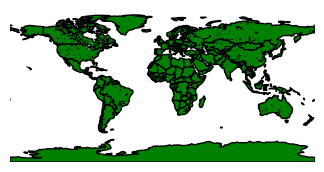

In [3]:
run_game()

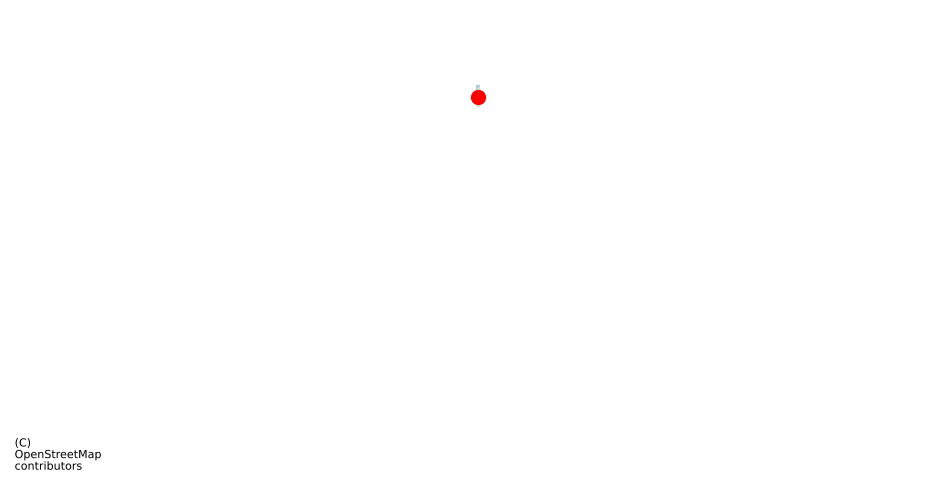

In [143]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx

# Coordinates (latitude, longitude)
lat, lon = 48.8566, 2.3522  # Example: Paris

# Create a GeoDataFrame with the point
gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs="EPSG:4326")

# Convert to Web Mercator (required by contextily)
gdf = gdf.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
gdf.plot(ax=ax, color='red', markersize=100)

# Add OpenStreetMap tiles
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set extent to show the entire world
world_buffer = 2e7  # ~20,000 km in meters
ax.set_xlim(-world_buffer, world_buffer)
ax.set_ylim(-world_buffer/2, world_buffer/2)  # latitude range is smaller

plt.axis('off')  # optional, hide axes
plt.show()

In [141]:
pip install contextily

   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   ---- ----------------------------------- 2.9/25.4 MB 13.7 MB/s eta 0:00:02
   -------- ------------------------------- 5.5/25.4 MB 13.4 MB/s eta 0:00:02
   ----------- ---------------------------- 7.3/25.4 MB 12.4 MB/s eta 0:00:02
   -------------- ------------------------- 9.4/25.4 MB 11.9 MB/s eta 0:00:02
   ------------------ --------------------- 12.1/25.4 MB 11.4 MB/s eta 0:00:02
   ----------------------- ---------------- 14.7/25.4 MB 11.8 MB/s eta 0:00:01
   -------------------------- ------------- 16.8/25.4 MB 11.5 MB/s eta 0:00:01
   ------------------------------ --------- 19.4/25.4 MB 11.4 MB/s eta 0:00:01
   ----------------------------------- ---- 22.3/25.4 MB 11.6 MB/s eta 0:00:01
   ---------------------------------------  25.2/25.4 MB 11.8 MB/s eta 0:00:01
   ---------------------------------------- 25.4/25.4 MB 11.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
